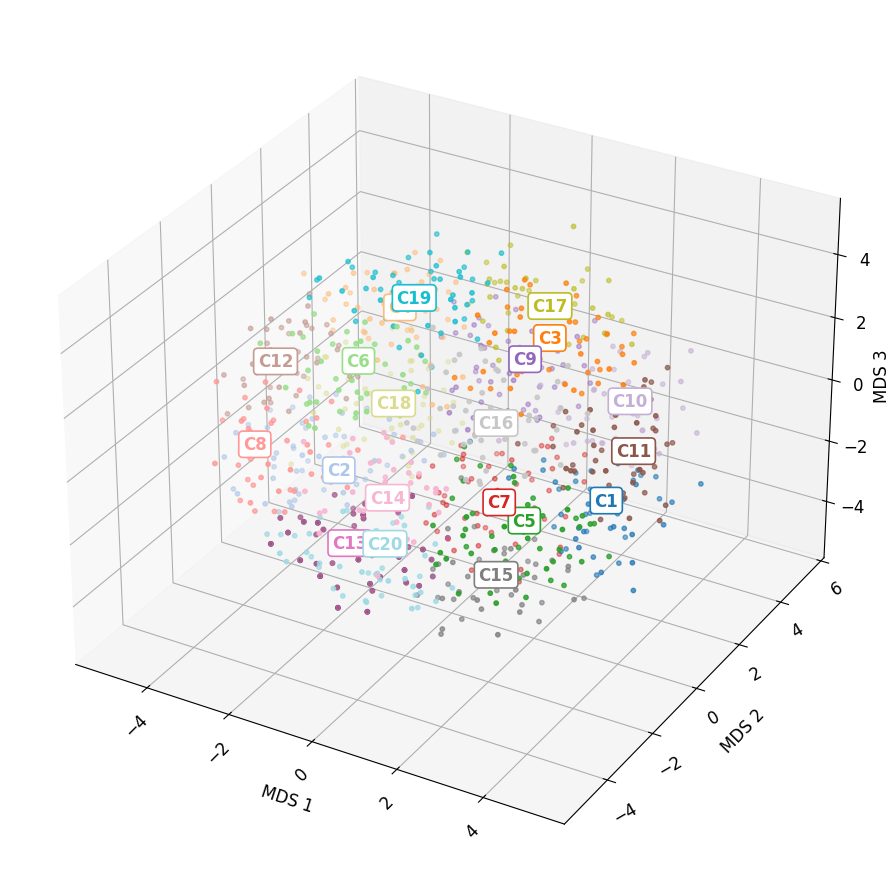

In [1]:
"""
cluster_permeability_mds_kmeans.py

Clustering of 1000 conditional permeability realizations using
squared-Euclidean dissimilarity, multidimensional scaling (MDS),
and k-means. The resulting cluster medoids define the training
vector. One held-out realization per cluster defines the
validation vector. The resulting HDF5 datasets contain
Perm and Por under 'inputs/' group, structured for surrogate input.

Corresponds to Section 2.2.2 and Figure 4 in the manuscript.
"""

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from matplotlib.ticker import ScalarFormatter
from pathlib import Path

# ----------------------------------------------------------------------
# Parameters
# ----------------------------------------------------------------------

H5_PATH         = "Combined_1000_Sample.h5"   # Input HDF5 with full ensemble
N_CLUSTERS      = 20                          # Number of clusters
TIME_IDX        = 0                           # Time index t=0 for static properties
CHANNEL_PERM    = 0                           # Channel index for permeability
CHANNEL_POR     = 1                           # Channel index for porosity

TRAIN_H5        = "train_data.h5"             # Output: cluster medoids
VALID_H5        = "valid_data.h5"             # Output: held-out samples

RNG             = np.random.default_rng(42)   # Reproducibility

FIG_DIR         = Path("Figures")
FIG_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------------------
# Load permeability fields
# ----------------------------------------------------------------------

with h5py.File(H5_PATH, "r") as f:
    dset = f["comb_input"]  # shape: (N, T, C, Z, Y, X)
    N    = dset.shape[0]
    perm_all = dset[:, TIME_IDX, CHANNEL_PERM].astype(np.float32)  # (N, 24, 60, 60)

# ----------------------------------------------------------------------
# MDS embedding from dissimilarity matrix
# ----------------------------------------------------------------------

flat_perm = perm_all.reshape(N, -1)
D_sq      = pairwise_distances(flat_perm, metric="sqeuclidean")

mds = MDS(n_components=3, dissimilarity="precomputed", n_init=4, random_state=42)
X_3d = mds.fit_transform(D_sq)  # embedded coordinates in ℝ³

# ----------------------------------------------------------------------
# K-means clustering in MDS space
# ----------------------------------------------------------------------

km       = KMeans(n_clusters=N_CLUSTERS, random_state=42)
labels   = km.fit_predict(X_3d)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X_3d)

train_indices = closest

valid_indices = np.array([
    RNG.choice(np.setdiff1d(np.where(labels == c)[0], [closest[c]]))
    for c in range(N_CLUSTERS)
])

# ----------------------------------------------------------------------
# Save Figure 4: MDS embedding with annotated cluster centers
# ----------------------------------------------------------------------

cmap = plt.get_cmap("tab20", N_CLUSTERS)

fig = plt.figure(figsize=(9, 9))
ax  = fig.add_subplot(111, projection="3d")

# Base scatter
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, cmap=cmap, s=10)

# Optional: Highlight one darkened cluster (e.g., C14 = cluster 12)
dark_cluster = 12
base_rgba    = cmap(dark_cluster)
dark_rgba    = tuple(0.05 * np.array(base_rgba[:3])) + (base_rgba[3],)  # 5 % brightness
mask         = labels == dark_cluster
ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], c=[dark_rgba], s=10, zorder=5)

# Cluster labels C1 … C20
for cid, ridx in enumerate(closest):
    clr = cmap(cid)
    ax.text(
        X_3d[ridx, 0], X_3d[ridx, 1], X_3d[ridx, 2],
        f"C{cid+1}",
        color=clr,
        bbox=dict(
            boxstyle="round,pad=0.25",
            facecolor="white",
            edgecolor=clr,
            linewidth=1.2,
        ),
        fontweight="bold",
        fontsize=12,
        rotation=20,
        ha="center", va="center",
        zorder=10
    )

ax.set_xlabel("MDS 1", labelpad=8, rotation=30, fontsize=12)
ax.set_ylabel("MDS 2", labelpad=8, rotation=-25, fontsize=12)
ax.set_zlabel("MDS 3", labelpad=1, rotation=90, fontsize=12)
ax.zaxis.set_rotate_label(False)

for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.set_major_formatter(ScalarFormatter(useMathText=False))
    axis.offsetText.set_visible(False)

ax.tick_params(axis="x", which="major", labelrotation=45, labelsize=12)
ax.tick_params(axis="y", which="major", labelrotation=30, labelsize=12)
ax.tick_params(axis="z", which="major",              labelsize=12)

fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

plt.tight_layout()
plt.savefig(FIG_DIR / "Fig4.png", dpi=600, bbox_inches="tight", transparent=True)
plt.show()

# ----------------------------------------------------------------------
# Write HDF5 datasets for train and valid splits
# ----------------------------------------------------------------------

def write_split(filename, indices):
    with h5py.File(filename, "w") as fout, h5py.File(H5_PATH, "r") as fin:
        src = fin["comb_input"]
        n   = len(indices)

        g_inputs = fout.create_group("inputs")
        d_perm   = g_inputs.create_dataset("Perm", shape=(n, 1, 1, 24, 60, 60), dtype=src.dtype)
        d_por    = g_inputs.create_dataset("Por",  shape=(n, 1, 1, 24, 60, 60), dtype=src.dtype)

        for i_out, i_src in enumerate(indices):
            d_perm[i_out, 0, 0] = src[i_src, TIME_IDX, CHANNEL_PERM]
            d_por [i_out, 0, 0] = src[i_src, TIME_IDX, CHANNEL_POR]

write_split(TRAIN_H5, train_indices)
write_split(VALID_H5, valid_indices)
